In [3]:
import os,sys
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
import transforms as T
from engine import train_one_epoch
from utils import * 
from datasets import PennFudanDataset

In [4]:
data_path = './data/PennFudanPed'
save_path = './parameters'
num_epoch = 30

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
trainset = PennFudanDataset(data_path, get_transform(train=True))
testset = PennFudanDataset(data_path, get_transform(train=False))

indices = torch.randperm(len(trainset)).tolist()
dataset = torch.utils.data.Subset(trainset, indices[:-1])
dataset_test = torch.utils.data.Subset(testset, indices[-1:])

trainLoader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
testLoader = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [16]:
mobilenet_weight = torch.load(os.path.join(save_path, 'mobilenet.pth'))
backbone = torchvision.models.mobilenet_v2().features
backbone.load_state_dict(mobilenet_weight, strict=False)
# backbone = torchvision.models.mobilenet_v2(weights=mobilenet_weight).features

backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005)

In [17]:
for epoch in range(num_epoch):
    train_one_epoch(model, optimizer, trainLoader, device, epoch, print_freq=10)
torch.save(model.state_dict(), os.path.join(save_path, 'detector.pth'))

Epoch: [0]  [  0/169]  eta: 0:05:18  lr: 0.000069  loss: 1.4680 (1.4680)  loss_classifier: 0.6651 (0.6651)  loss_box_reg: 0.0547 (0.0547)  loss_objectness: 0.7092 (0.7092)  loss_rpn_box_reg: 0.0391 (0.0391)  time: 1.8848  data: 0.0089  max mem: 2621
Epoch: [0]  [ 10/169]  eta: 0:00:40  lr: 0.000664  loss: 1.4530 (1.4350)  loss_classifier: 0.6183 (0.6057)  loss_box_reg: 0.0491 (0.0598)  loss_objectness: 0.7139 (0.7121)  loss_rpn_box_reg: 0.0449 (0.0574)  time: 0.2523  data: 0.0101  max mem: 2897
Epoch: [0]  [ 20/169]  eta: 0:00:25  lr: 0.001259  loss: 1.3343 (1.3262)  loss_classifier: 0.4745 (0.4884)  loss_box_reg: 0.0554 (0.0763)  loss_objectness: 0.7051 (0.7048)  loss_rpn_box_reg: 0.0446 (0.0567)  time: 0.0863  data: 0.0108  max mem: 3007
Epoch: [0]  [ 30/169]  eta: 0:00:19  lr: 0.001853  loss: 1.1501 (1.2365)  loss_classifier: 0.2753 (0.4018)  loss_box_reg: 0.1101 (0.0916)  loss_objectness: 0.6868 (0.6911)  loss_rpn_box_reg: 0.0355 (0.0520)  time: 0.0834  data: 0.0114  max mem: 3089


In [18]:
imgs, targets= next(iter(testLoader))
img = imgs[0]
sample = img.permute(1,2,0).cpu().numpy()
target = targets[0]
boxes = target['boxes'].cpu().numpy().astype(int)
print(boxes)

[[218  43 399 330]]


In [19]:
model.eval()
device = torch.device('cpu')
model = model.to(device)
outputs = model(img.unsqueeze(0))
outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


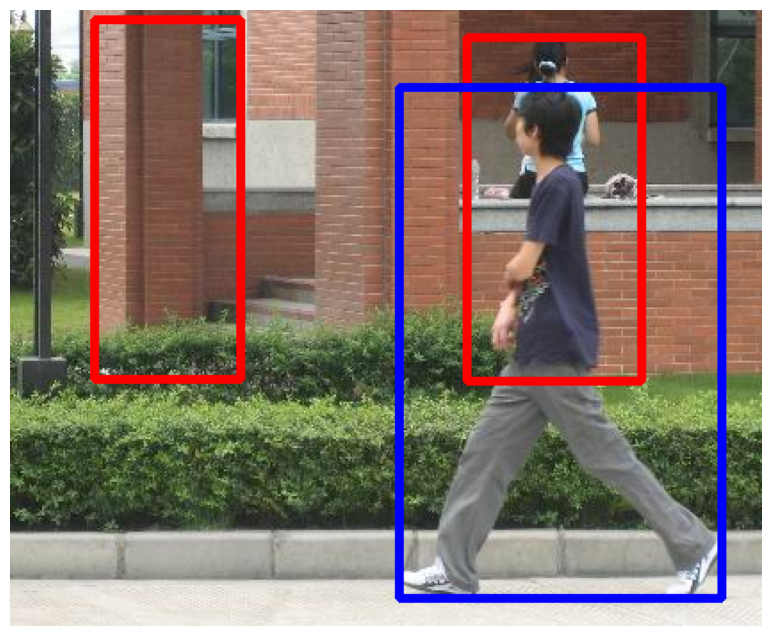

In [20]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

count = 0
mean_score = torch.mean(outputs[0]['scores'])

for box, score in zip(outputs[0]['boxes'].int(), outputs[0]['scores']):
    if score > 0.75:
        cv2.rectangle(sample,(box[0].item(), box[1].item()),(box[2].item(), box[3].item()),(220, 0, 0), 3)
        count += 1
        
for box in zip(targets[0]['boxes'].int()):
    box = box[0]
    cv2.rectangle(sample,(box[0].item(), box[1].item()),(box[2].item(), box[3].item()),(0, 0, 255), 3)
    count += 1
    
ax.set_axis_off()
ax.imshow(sample)
